In [1]:
import numpy as np
import scipy.stats as stats
from particles.kalman import Kalman, LinearGauss
from particles.core import SMC, multiSMC, FeynmanKac
import particles.state_space_models as ssms
from sdes.auxiliary_bridges import LocalLinearOUProp 
from sdes.sdes import OrnsteinUhlenbeck, ManualOptOU
from sdes.tools import start_points_paths_to_array, struct_array_to_array, plot_simulations
from sdes.feynman_kac import BootstrapDA, ForwardGuidedDA
from sdes.path_integrals import log_girsanov
import matplotlib.pyplot as plt
import seaborn as sb

Consider the Ornstein-Uhlenbeck process in one-dimension:

$$dV(s) = -\rho V(s) ds + \phi dW(s) \qquad V(0) = 0.$$ (1)

This process is observed at $T$ discrete times $s_1 < s_2 < \dots < s_T$, with noise. So we are working with a continuous time set $\mathcal{S} = [0, S]$ and a discrete one $\mathcal{T} = \{1, \dots T\}$. We set $V_t = V(s_t)$

We assume for simplicity that observation times are equidistant $s_t - s_{t-1} = \Delta s = 1$, and we define each observation density $p_t(y_t|v_t)$ to be linear, Gaussian:

$$Y_t |V_t = v_t \sim \mathcal{N}(v_t, \eta^2)$$ (2)

Equation (1)-(2) defines a CD-SSM with parameters $\theta = (\rho, \phi, \eta^2)$. As the OU process is a linear SDE, it has a tractable transition density $p_t(v_t|v_{t-1})$, given by:

$$V_t|V_{t-1} = v_{t-1} \sim \mathcal{N}(e^{-\rho \Delta s}v_{t-1}, \frac{\phi^2}{2\rho}(1 - e^{-2\rho \Delta s}))$$

Thus, the random variables $(V_{1:T}, Y_{1:T})$ form a linear, Gaussian state space model, and it is possible to derive analytically the filtering and smoothing distributions, through Kalman filtering and smoothing. One can also implement particle filters/smoothers on discrete space, without data augmentation, with the optimal proposal being analytically tractable. Finally, the data augmentation approaches outlined in the contribution can be used.

We define the unknowns in this model below:

We fix parameter values $\theta = (\rho, \phi, \eta^2) = (0.2, 0.3, 0.01^2)$

In [2]:
Delta_s = 1.; rho = 0.2; phi = 0.3; eta = 0.01
T = 100; N = 1000 # Length of the data  #Number of particles for pfs
ou_params = {'rho': rho, 'phi': phi}
ou_model_params = {**ou_params, 'eta': 0.01}
linear_gauss_params = {'sigmaY': eta,
                       'rho': np.exp(-rho*Delta_s),
                       'sigmaX': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s))),
                       'sigma0': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s)))
                      }

In [3]:
linear_gauss_params = {'sigmaY': eta,
                       'rho': np.exp(-rho*Delta_s),
                       'sigmaX': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s))),
                       'sigma0': np.sqrt((phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*Delta_s)))
                      }

In [4]:
np.random.seed(1) # Set random seed
LGSSM = LinearGauss(**linear_gauss_params)
x, y = LGSSM.simulate(T) # Generate synthetic data

# Test that simulations from OU SDE are working

In [5]:
OU = OrnsteinUhlenbeck(**ou_params) # My implementation of Ornstein Uhlenbeck
num = 10000 # number of simulated paths #number of imputed points on the path
OU_sims = OU.simulate(N, 0., t_start=0., t_end=1., num=num, milstein=False)

We check that these simulations are generated from the correct OU process, using the ks test and a histogram:
The end points should match the distribution: 
$V_t | V_{t-1} = v_{t-1} \sim \mathcal{N}(e^{-\rho \Delta s}v_{t-1}, \frac{\phi^2}{2\rho}(1 - e^{-2\rho \Delta s}))$

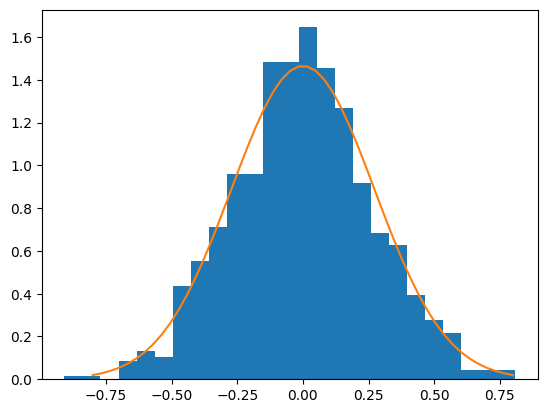

In [6]:
plt.hist(OU_sims['1.0'], bins=25, density=True);
t = np.linspace(-0.8, 0.8, 50);
plt.plot(t, stats.norm.pdf(t, scale=linear_gauss_params['sigmaX']));

In [7]:
stats.kstest(OU_sims['1.0'], lambda x: stats.norm.cdf(x, scale=linear_gauss_params['sigmaX']))

KstestResult(statistic=0.027259581929553245, pvalue=0.43950462805617285, statistic_location=0.16668974965019212, statistic_sign=1)

We test the implementation of the `LocalLinearOuProp` proposal SDE: this is the SDE that corresponds to the optimal proposal
for the OU process, given a noisy observation $y_1$.

The local linear OU proposal, is the following SDE:

$$dV(s) = b^{\rightarrow}(s, V(s); y_1)ds + \sigma(s, V(s))dW(s) \qquad V(0) = v_0$$

The drift function is given by:
$b^{\rightarrow}(s, v) =  b(s, v) + \sigma(s, v)\sigma^T(s, v)\nabla_v [\tilde{\rho}_{y_1}(s, v)]$

$\tilde{\rho}_{y_1}(t, x)$ is the distribution of $Y_1 | X_t = x$, which is given by:

$$Y_1 | V(s) = v \sim \mathcal{N}(A(1-s)v + B(1-s), C(1-s) + \eta^2)$$

Where we have 

- $A(s) = e^{-\rho * s}$
- $B(s) = 0.$
- $C(s) = \frac{\phi^2}{2\rho}(1 - e^{-2\rho s})$

Therefore, the expression $\nabla_x [\tilde{\rho}_{y_1}(s, v)]$ in this case, is given by:

$$\nabla_x [\tilde{\rho}_{y_1}(s, v)] = A(1-s) \times \frac{y_1 - A(1-s)x - B(1-s)}{C(1-s) + \eta^2}$$

We generate some simulations from this SDE, assuming that we have observed $y_1$:

In [8]:
y_1 = 1.;
OU_opt_proposal = LocalLinearOUProp(OU, 0., 1., y_1, eta ** 2)
opt_proposal_sims = OU_opt_proposal.simulate(N, 0., num)

For simulations from the optimal proposal, if the simulations are correct, the end points should match the distribution $V_1 | Y_1=y_1, V_{0} = 0$. This distribution is given by:

$$V_1 | Y_1 = y_1, V_0 = v_0 \sim \mathcal{N}(\mu(v_0, y_1), \sigma^2)$$

With:
- $\mu(v_0, y_1) = A(1)v_0 + \frac{C(1)}{C(1) + \eta^2}[y_1 - A(1)v_0]$
- $\sigma^2(v_0, y_1)) = C(1)[1-\frac{C(1)}{C(1) + \eta^2}]$

We can check this formally:

In [9]:
LGSSM = LinearGauss(**linear_gauss_params)
x, y = LGSSM.simulate(T) # Generate synthetic data

y[0][0] = 1. # Manually set the first data point to 1, to replicate experiment.

In [10]:
def A(t):
    return np.exp(-rho*t)

def C(t):
    return (phi ** 2)/(2*rho) * (1 - np.exp(-2*rho*t))

v_0 = 0.

def mu_cond(v_0, y_1):
    return A(1)*v_0 + C(1)/(C(1) + eta ** 2) * (y_1 - A(1)*v_0)
    
sigma_cond = np.sqrt(C(1) * (1 - C(1)/(C(1) + eta ** 2)))

In [11]:
manual_opt_ou = ManualOptOU(rho=rho, phi=phi, y=y_1)
manual_opt_ou_sims = manual_opt_ou.simulate(N, 0., t_start=0., t_end=1., num=num, milstein=False)

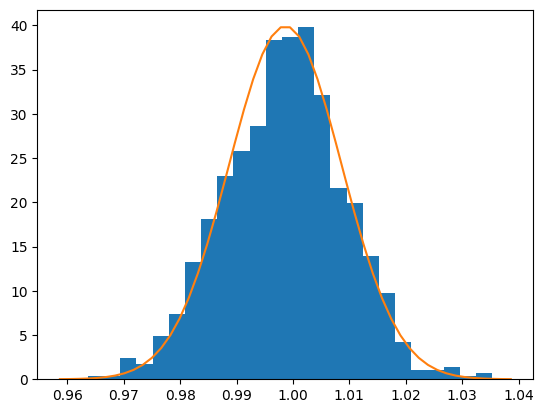

In [12]:
plt.hist(manual_opt_ou_sims['1.0'], bins=25, density=True);
t = np.linspace(mu_cond(0, 1.) - 4*sigma_cond, mu_cond(0, 1.) + 4*sigma_cond, 50);
plt.plot(t, stats.norm.pdf(t, loc=mu_cond(0, 1.), scale=sigma_cond));

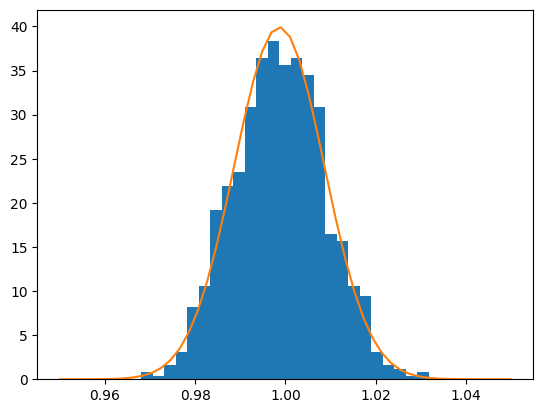

In [13]:
plt.hist(opt_proposal_sims['1.0'], bins=25, density=True);
t = np.linspace(0.95, 1.05, 50);
plt.plot(t, stats.norm.pdf(t, loc=mu_cond(0, 1.), scale=sigma_cond));

# Test that the Path Integrals are working

We test a single pathspace importance sampling step, to ensure that the path integral from Girsanov's formula is being evaluated correctly: we have the following unnormalised change of measure on the pathspace:

$$\mathbb{Q}[dx] = \frac{1}{L}G(x)\mathbb{M}[dx]$$

In this expression, the proposal law $\mathbb{M}[dx]$ is that of the optimal proposal SDE:

$$dV(s) = b^{\rightarrow}(s, V(s); y_1)ds + \sigma(s, V(s))dW(s) \qquad V(0) = v_0$$

The drift function is given by:
$b^{\rightarrow}(s, v) =  b(s, v) + \sigma(s, v)\sigma^T(s, v)\nabla_v [\tilde{\rho}_{y_1}(s, v)]$

$\tilde{\rho}_{y_1}(s, v)$ is the distribution of $Y_1 | V(s) = v$, which is given by:

$$Y_1 | V(s) = v \sim \mathcal{N}(A(1-s)v + B(1-s), C(1-s) + \eta^2)$$

For this choice of $\mathbb{M}$, the proposal distribution matches the target. Therefore, the Radon-Nikodyn derivative $G(x)$ is constant. This should therefore lead to an Effective Sample Size that matches the number of particles.

In [14]:
test_nums = {10: [], 100: [], 1000: [], 10000: []}
for _num in test_nums.keys():
    forward_proposal_fk = ForwardGuidedDA(y, _num, eta, **ou_params)
    forward_proposal_pf = SMC(fk=forward_proposal_fk, N=N, store_history=True)
    next(forward_proposal_pf)
    ESS = forward_proposal_pf.summaries.ESSs
    test_nums[_num] = ESS

In [15]:
test_nums

{10: [123.7430212258053],
 100: [318.7811604783657],
 1000: [734.7048524273574],
 10000: [959.156645858758]}

As the number of imputed points increases, the bias in the evaluation of the path integral is eliminated. Without bias in the weights, the exact evaluation of the weights should be $G(x) \propto 1$, resulting in an ESS that matches the number of particles (in this case $N=1000$). 

(Manual implementation of the above experiment, without using the same number of particles):

In [16]:
b_1 = OU_opt_proposal._b_time_shifted
b_2 = OU_opt_proposal.b
Cov = OU_opt_proposal.Cov
step = 1/num
num_plus_1 = num + 1
X = start_points_paths_to_array(np.zeros(N), opt_proposal_sims)
log_g_wgts = log_girsanov(X, b_1, b_2, Cov, step)

In [17]:
# Z = stats.norm.rvs(loc=mu_cond(0, 1.), scale=sigma_cond, size=N)
Z = opt_proposal_sims['1.0']

obvn_log_d = stats.norm.logpdf(y_1, loc=Z, scale=eta)
signal_log_d = stats.norm.logpdf(Z, loc=0., scale=np.sqrt(C(1)))
opt_prop_log_d = stats.norm.logpdf(Z, loc=mu_cond(0, 1.), scale=sigma_cond)

log_wgts = obvn_log_d + log_g_wgts
# log_wgts = obvn_log_d + signal_log_d - opt_prop_log_d


In [18]:
def ESS(log_wgts):
    wgts = np.exp(log_wgts)
    W = wgts/np.sum(wgts)
    W_sq = np.square(W)
    ESS = 1/np.sum(W_sq)
    return ESS

In [19]:
# x_arr = np.array([arr[0] for arr in x])
# y_arr = np.array([arr[0] for arr in y])
# t_arr = np.arange(0, 100)
# plt.plot(t_arr, x_arr, label='x')
# plt.plot(t_arr, y_arr, 'o', label='y');
# plt.legend()
# plt.show()

In [20]:
from sdes.collectors import SDEMoments
from particles.collectors import Moments

num = 100

In [21]:

# Discrete Time FK
bootstrap_fk = ssms.Bootstrap(ssm=LGSSM, data=y)
guided_fk = ssms.GuidedPF(ssm=LGSSM, data=y)
auxiliary_fk = ssms.AuxiliaryPF(ssm=LGSSM, data=y)

# Continuous Time FK
bootstrap_da_fk = BootstrapDA(y, num, eta, **ou_params)
forward_proposal_fk = ForwardGuidedDA(y, num, eta, **ou_params)

#Particle Filters in Discrete Time
bootstrap_pf = SMC(fk=bootstrap_fk, N=N, collect=[Moments()], store_history=True)
guided_pf = SMC(fk=guided_fk, N=N, collect=[Moments()], store_history=True)
auxiliary_pf = SMC(fk=auxiliary_fk, N=N, collect=[Moments()], store_history=True)

#Particle Filters in Continuous Time
bootstrap_da_pf = SMC(fk=bootstrap_da_fk, N=N, collect=[SDEMoments()], store_history=True)
forward_proposal_pf = SMC(fk=forward_proposal_fk, N=N, collect=[SDEMoments()], store_history=True)

bootstrap_pf.run() 
guided_pf.run() #Uses the optimal proposal
auxiliary_pf.run() #Uses the optimal auxiliary weight

bootstrap_da_pf.run()  # Bootstrap filter that uses simulations from the SDE
forward_proposal_pf.run() # Guided filter that uses log girsanov weights 


# Kalman Filter benchmark
kf = Kalman(ssm=LGSSM, data=y)
kf.filter()

In [22]:
def extract_sde_means(pf):
    sde_moments = pf.summares.sDEMoments
    return np.array([])
    

In [23]:
# kf_means = np.array([kf.filt[i].mean[0] for i in range(T)])
# bf_means = np.array([bootstrap_pf.summaries.moments['mean'][i] for i in range(T)])
# gf_means = np.array([guided_pf.summaries.moments['mean'][i] for i in range(T)])
# bs_da_pf_means = np.array([bootstrap_da_pf.summaries.sDEMoments[i]['mean'] for i in range(T)])
# gd_da_pf_means = np.array([bootstrap_da_pf.summaries.sDEMoments[i]['mean'] for i in range(T)])

In [24]:
t = 30
mean = kf.filt[t].mean #Extract the mean
bootstrap_pf_hist = bootstrap_pf.hist # Particle History object
X, wgts = bootstrap_pf_hist.X[t], bootstrap_pf_hist.wgts[t] 

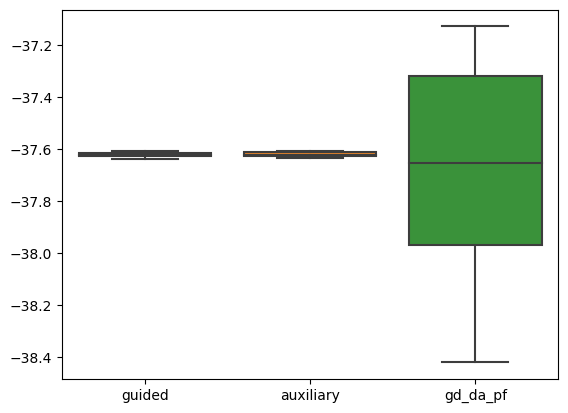

In [25]:
results = multiSMC(nruns=10, collect=[], fk={'guided': guided_fk, 
                                   'auxiliary': auxiliary_fk, 
                                   'gd_da_pf': forward_proposal_fk}, N=1000)
sb.boxplot(x=[r['fk'] for r in results], y=[r['output'].logLt for r in results]);

In [26]:
true_py = np.sum([a[0][0] for a in kf.logpyt])
true_py

-37.62496425872666

In [27]:
gd_pfs = [r['output'] for r in results if r['fk'] == 'gd_da_pf']

In [28]:
bootstrap_pf.logLt, guided_pf.logLt, auxiliary_pf.logLt, bootstrap_da_pf.logLt, forward_proposal_pf.logLt 

(-290.6493786459915,
 -37.629760782050724,
 -37.62447589848167,
 -471.5509964598585,
 -37.810774748303515)

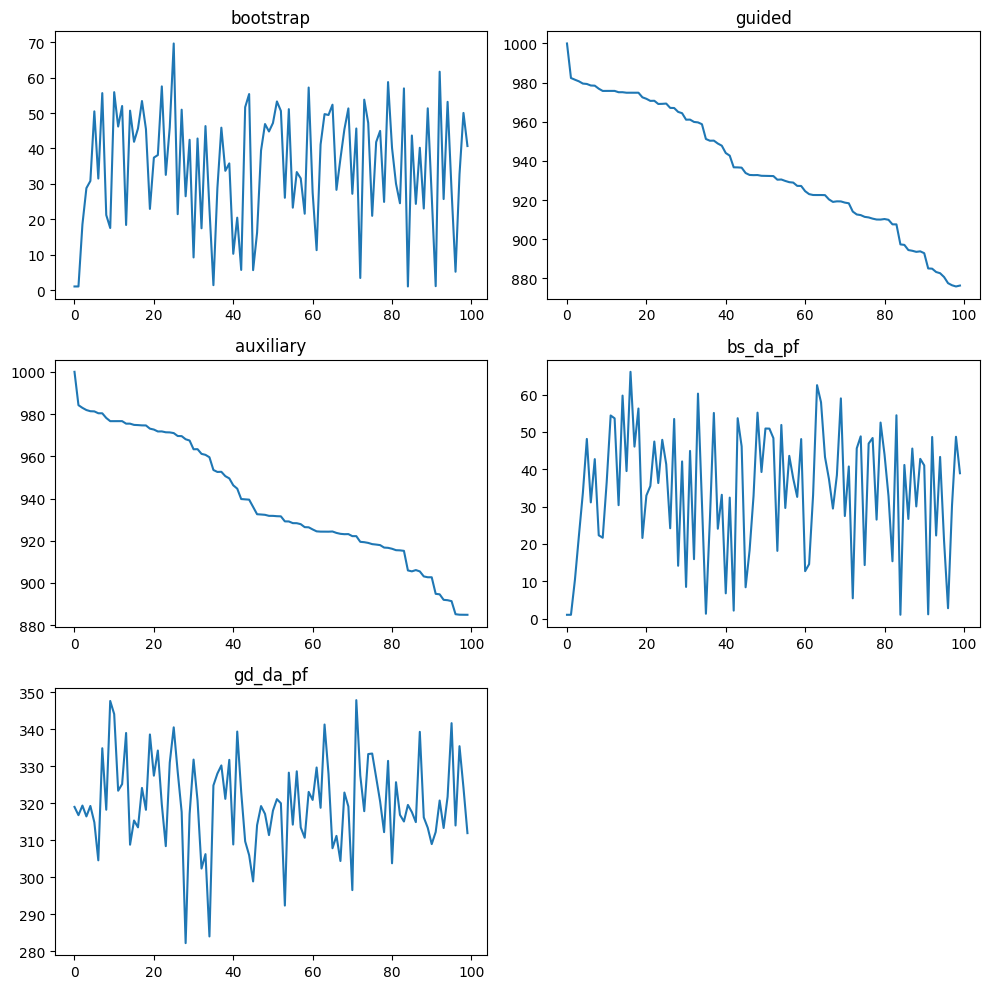

In [29]:
pfs = [bootstrap_pf, guided_pf, auxiliary_pf, bootstrap_da_pf, forward_proposal_pf]
labels = ['bootstrap', 'guided', 'auxiliary', 'bs_da_pf', 'gd_da_pf']

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes = axes.reshape(-1,)

for i in range(5):
    ax = axes[i]
    ax.plot(pfs[i].summaries.ESSs)
    ax.set_title(labels[i])

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()